In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

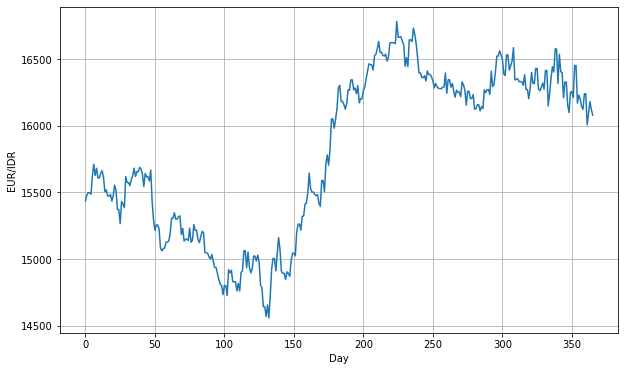

In [58]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./currency_data.csv') as csvfile:
  
    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for i,row in enumerate(reader):
        time_step.append(int(i))
        sunspots.append(float(row[1]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='EUR/IDR')

In [59]:
# Define the split time
split_time = 300

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [60]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [61]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [62]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                630       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 951
Trainable params: 951
Non-trainable params: 0
_________________________________________________________________


In [63]:

# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)


In [64]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
9/9 [==============================] - 1s 42ms/step - loss: 21538.7852 - lr: 1.0000e-08
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 19544.9688 - lr: 1.1220e-08
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 16566.2812 - lr: 1.2589e-08
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 13911.8389 - lr: 1.4125e-08
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 11974.2451 - lr: 1.5849e-08
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 9879.6299 - lr: 1.7783e-08
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 7443.1621 - lr: 1.9953e-08
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - loss: 4406.3174 - lr: 2.2387e-08
Epoch 9/100
9/9 [==============================] - 0s 5ms/step - loss: 1055.4320 - lr: 2.5119e-08
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 744.1376 - lr: 2.8184e-08
Epoch 11/100
9

Epoch 84/100
9/9 [==============================] - 0s 2ms/step - loss: 15700.9951 - lr: 1.4125e-04
Epoch 85/100
9/9 [==============================] - 0s 4ms/step - loss: 15700.9824 - lr: 1.5849e-04
Epoch 86/100
9/9 [==============================] - 0s 3ms/step - loss: 15700.9678 - lr: 1.7783e-04
Epoch 87/100
9/9 [==============================] - 0s 3ms/step - loss: 15700.9531 - lr: 1.9953e-04
Epoch 88/100
9/9 [==============================] - 0s 4ms/step - loss: 15700.9355 - lr: 2.2387e-04
Epoch 89/100
9/9 [==============================] - 0s 5ms/step - loss: 15700.9180 - lr: 2.5119e-04
Epoch 90/100
9/9 [==============================] - 0s 2ms/step - loss: 15700.8965 - lr: 2.8184e-04
Epoch 91/100
9/9 [==============================] - 0s 5ms/step - loss: 15700.8730 - lr: 3.1623e-04
Epoch 92/100
9/9 [==============================] - 0s 4ms/step - loss: 15700.8447 - lr: 3.5481e-04
Epoch 93/100
9/9 [==============================] - 0s 3ms/step - loss: 15700.8164 - lr: 3.9811e-04


(1e-08, 0.001, 0.0, 20000.0)

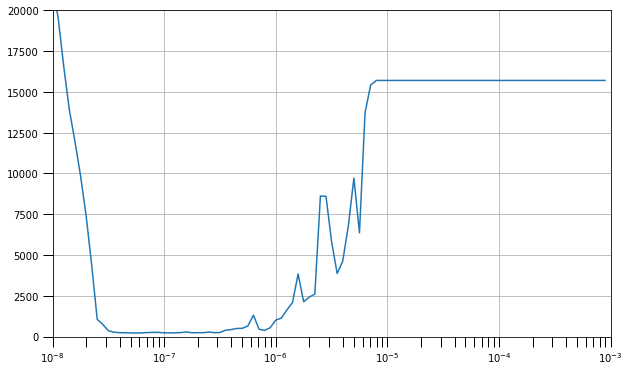

In [65]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 20000])

(1e-08, 1e-07, 0.0, 15000.0)

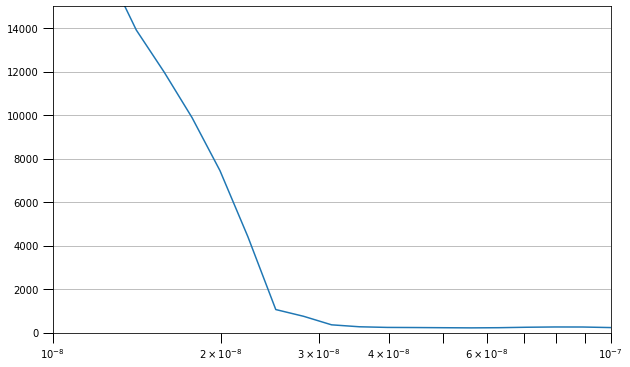

In [66]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-7, 0, 15000])

In [67]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [69]:
# Set the learning rate
learning_rate = 3e-8

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [70]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
9/9 [==============================] - 1s 8ms/step - loss: 20732.9785 - mae: 20733.4785
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 15468.3945 - mae: 15468.8945
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 11110.2715 - mae: 11110.7715
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 7061.2681 - mae: 7061.7681
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 2681.2180 - mae: 2681.7180
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 1080.3901 - mae: 1080.8894
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - loss: 594.1132 - mae: 594.6132
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 435.9865 - mae: 436.4865
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 336.8374 - mae: 337.3361
Epoch 10/100
9/9 [==============================] - 0s 5ms/step - loss: 231.4565 - mae: 231.9525
Epoch 11/100
9/9 [===

9/9 [==============================] - 0s 3ms/step - loss: 197.4090 - mae: 197.9090
Epoch 86/100
9/9 [==============================] - 0s 3ms/step - loss: 199.5060 - mae: 200.0047
Epoch 87/100
9/9 [==============================] - 0s 3ms/step - loss: 192.4115 - mae: 192.9113
Epoch 88/100
9/9 [==============================] - 0s 4ms/step - loss: 192.5286 - mae: 193.0286
Epoch 89/100
9/9 [==============================] - 0s 3ms/step - loss: 192.5069 - mae: 193.0069
Epoch 90/100
9/9 [==============================] - 0s 5ms/step - loss: 200.9828 - mae: 201.4828
Epoch 91/100
9/9 [==============================] - 0s 3ms/step - loss: 194.7909 - mae: 195.2909
Epoch 92/100
9/9 [==============================] - 0s 2ms/step - loss: 192.9627 - mae: 193.4627
Epoch 93/100
9/9 [==============================] - 0s 3ms/step - loss: 191.9542 - mae: 192.4542
Epoch 94/100
9/9 [==============================] - 0s 5ms/step - loss: 190.9692 - mae: 191.4679
Epoch 95/100
9/9 [=========================

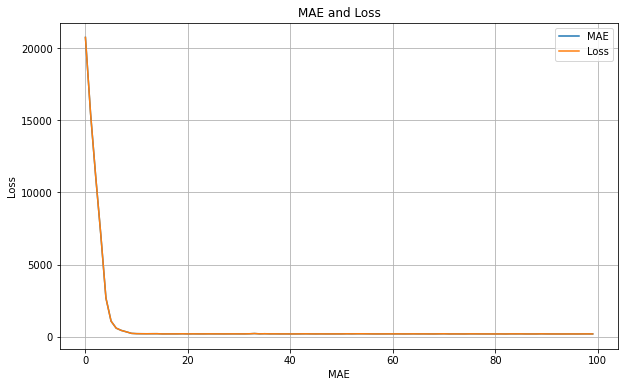

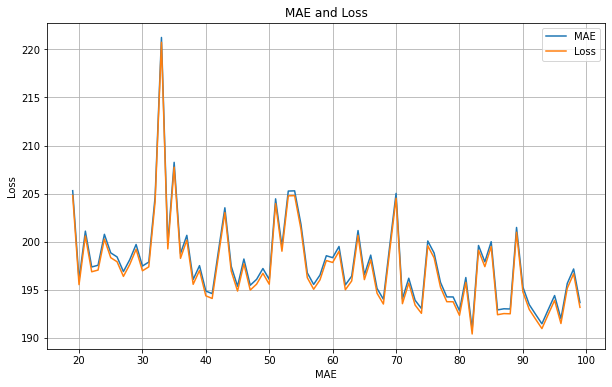

In [71]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [72]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

3/3 [==============================] - 0s 21ms/step


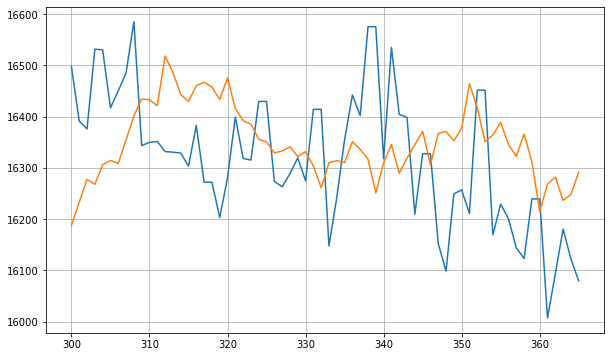

In [95]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

11/11 [==============================] - 0s 9ms/step


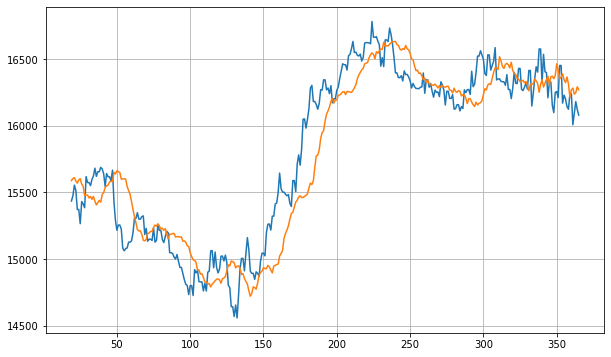

In [96]:
# Reduce the original series
forecast_series2 = series

# Use helper function to generate predictions
forecast2 = model_forecast(model, forecast_series2, window_size, batch_size)

# Drop single dimensional axis
results2 = forecast2.squeeze()
valid_y_series = series[window_size-1:]
valid_y_time = time[window_size-1:]

# Plot the results
plot_series(valid_y_time, (valid_y_series, results2))

In [100]:
# Compute the MAE valid
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

131.91058


In [101]:
print(f'2 last Actual Price = {x_valid[-2:]}, Predicted Price = {results[-2:]}')

2 last Actual Price = [16122.278893 16079.600092], Predicted Price = [16248.057 16291.694]


In [44]:
# import os
# path = "./saved_model"

# def get_model_dir():
#     """Returns the path where to save the current model.
#     The path is as follows: './saved_models/{incremental_integer}
#     Note: all sub-directories inside 'saved_models' must have an incremental integer as name

#     Returns:
#     - Path to save a new model (str) 
#     """
#     # create 'saved_models' directory if it does not exist
#     if not os.path.exists(path):
#         os.makedirs(path)

#     # check for model directories inside 'saved_models'
#     model_dirs = [int(i) for i in os.listdir(path)]

#     # if there is no prior model, current model has version 1
#     # otherwise, current model version is highest available version incremented by 1 
#     current_model = "1" if len(model_dirs)==0 else str(max(model_dirs)+1)

#     return path + "/" + current_model + "/"

In [45]:
# # !mkdir -p saved_model
# path = get_model_dir()
# model.save(path)

INFO:tensorflow:Assets written to: ./saved_model/2/assets


INFO:tensorflow:Assets written to: ./saved_model/2/assets


In [102]:
into_future = 30

# 1. Create function to make preds
def make_future_forecast(values, model, into_future, window_size=window_size) -> list:
    """
    Make future forecasts into_future steps after value ends.

    Returns future forecasts as a list of floats.
    """
    # 2. Create an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:]

    # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
    for _ in range(into_future):
        # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        # Append preds to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())

        # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-window_size:]

    return future_forecast
     

In [104]:
future_forecast = make_future_forecast(values=series,
                                       model=model,
                                       into_future=into_future,
                                       window_size=window_size)

1/1 [==============================] - 0s 32ms/step
Predicting on:
 [16327.528027 16152.48258  16098.499876 16249.379835 16256.899212
 16210.893186 16451.581219 16451.575726 16169.368866 16229.228031
 16200.87463  16143.846937 16123.24833  16239.40712  16239.418391
 16007.214956 16093.104725 16180.626251 16122.278893 16079.600092] -> Prediction: 16269.19921875

1/1 [==============================] - 0s 25ms/step
Predicting on:
 [16152.48258    16098.499876   16249.379835   16256.899212
 16210.893186   16451.581219   16451.575726   16169.368866
 16229.228031   16200.87463    16143.846937   16123.24833
 16239.40712    16239.418391   16007.214956   16093.104725
 16180.626251   16122.278893   16079.600092   16269.19921875] -> Prediction: 16209.3779296875

1/1 [==============================] - 0s 28ms/step
Predicting on:
 [16098.499876   16249.379835   16256.899212   16210.893186
 16451.581219   16451.575726   16169.368866   16229.228031
 16200.87463    16143.846937   16123.24833    16239.

1/1 [==============================] - 0s 51ms/step
Predicting on:
 [16209.37792969 16220.68261719 16219.84960938 16167.68457031
 16135.15820312 16229.25195312 16189.95507812 16129.98535156
 16149.78027344 16159.57128906 16139.09375    16147.46875
 16179.7578125  16180.06640625 16161.20605469 16174.04003906
 16180.77246094 16162.96777344 16160.95898438 16173.55957031] -> Prediction: 16158.1728515625

1/1 [==============================] - 0s 33ms/step
Predicting on:
 [16220.68261719 16219.84960938 16167.68457031 16135.15820312
 16229.25195312 16189.95507812 16129.98535156 16149.78027344
 16159.57128906 16139.09375    16147.46875    16179.7578125
 16180.06640625 16161.20605469 16174.04003906 16180.77246094
 16162.96777344 16160.95898438 16173.55957031 16158.17285156] -> Prediction: 16164.6611328125

1/1 [==============================] - 0s 41ms/step
Predicting on:
 [16219.84960938 16167.68457031 16135.15820312 16229.25195312
 16189.95507812 16129.98535156 16149.78027344 16159.57128906


In [105]:
next_time_steps = np.arange(time[-1] + 1, time[-1] + 1 + into_future)
next_time_steps

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
next_time_steps = np.insert(next_time_steps, 0, time[-1])
future_forecast = np.insert(future_forecast, 0, series[-1])

In [106]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps ( a series of points in time) against values (a series of values across timesteps)

    Parameters
    ----------
    timesteps: array of timestep values
    values: array of values across time
    format: style of plot, default "."
    start: where to start the plot (setting a value will index from start of timesteps & values)
    end: where to end the plot (similar to start but for the end)
    label: label to show on plot about values, default None
    """

    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Day")
    plt.ylabel("EUR/IDR Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

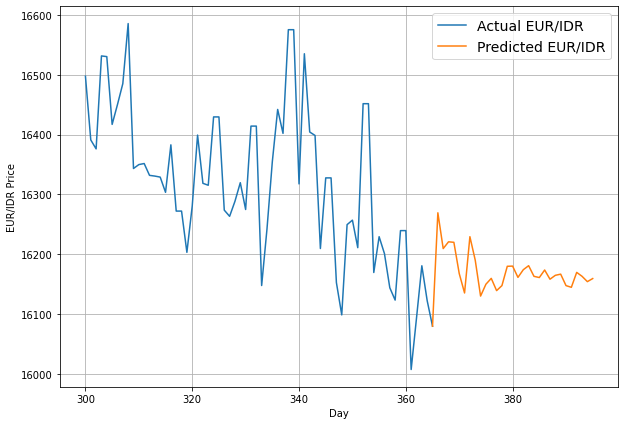

In [107]:
plt.figure(figsize=(10,7))
plot_time_series(time, series, start=300, format="-", label="Actual EUR/IDR")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted EUR/IDR")

In [ ]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt

# time_step = []
# sunspots = []
# time = np.array(time_step)
# series = np.array(sunspots)
# split_time = 300
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]

# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):  
#     dataset = tf.data.Dataset.from_tensor_slices(series)
#     dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#     dataset = dataset.map(lambda window: (window[:-1], window[-1]))
#     dataset = dataset.shuffle(shuffle_buffer)
#     dataset = dataset.batch(batch_size).prefetch(1)
#     return dataset

# window_size = 20
# batch_size = 32
# shuffle_buffer_size = 1000
# train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
                          
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
#     tf.keras.layers.Dense(10, activation="relu"),
#     tf.keras.layers.Dense(1)
# ])
# init_weights = model.get_weights()
# tf.keras.backend.clear_session()
# model.set_weights(init_weights)
# learning_rate = 2e-8
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
# history = model.fit(train_set,epochs=100)

# def model_forecast(model, series, window_size, batch_size):
#     dataset = tf.data.Dataset.from_tensor_slices(series)
#     dataset = dataset.window(window_size, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda w: w.batch(window_size))
#     dataset = dataset.batch(batch_size).prefetch(1)
#     forecast = model.predict(dataset)
#     return forecast

# forecast_series = series[split_time-window_size:-1]
# forecast = model_forecast(model, forecast_series, window_size, batch_size)
# results = forecast.squeeze()
# plot_series(time_valid, (x_valid, results))